# Chess AI - LexWolf

Placeholder

See [python-chess documentation](https://python-chess.readthedocs.io/en/latest/).

In [14]:
#!pip install lexwolf==0.1.4
try:
    import chess
    from lexwolf import *
except ModuleNotFoundError:
    !pip install chess
    #!pip install lexwolf==0.1.4
    try:
        import chess
        #from lexwolf import *
    except:
        raise AssertionError("Impossible to load 'chess'. Aboard.")
        
from tqdm import tqdm
from IPython.display import display, SVG
from time import time
import chess
import chess.svg
from random import shuffle, seed, randrange
import numpy as np
import pandas as pd
import random
from pathlib import Path
from functools import lru_cache
from math import floor

## Import data

In [15]:
op = pd.read_csv("/kaggle/input/all-chess-openings/openings_fen7.csv")

## Testing the library

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


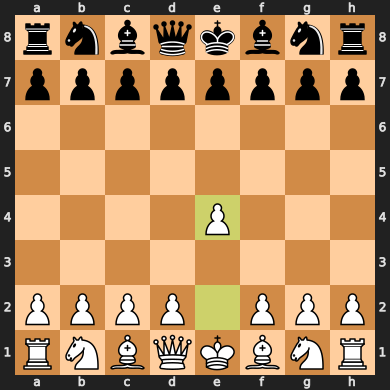

In [16]:
board = chess.Board()
print(board)

# Example move: Move the pawn from e2 to e4
move = chess.Move.from_uci("e2e4")
if move in board.legal_moves:
    board.push(move)

board

# 0. BitBoard class

In [17]:
COLOR_OFFSET = {chess.WHITE: 0, chess.BLACK: 1}
BOOL_BIN = {True: 1, False: 0}

a1 = 100  # material
a2 = 2  # b ctl
a3 = 2  # q ctl
a4 = 2  # r ctl
a5 = 2  # k ctl
a6 = 2  # p ctl
a7 = 2  # p pen
a8 = 2  # king exposed
a9 = 1  # king protected


class bitBoard:

    def __init__(self, board=None, bruteForce=False):
        self.bF = bruteForce
        self.__list = np.asarray([None] * (
                    768 + 5))  # private 773-bits bit array: 64*6*2 + 5 ~ 64 cases for each piece of each color plus side to move & castling rights
        self.__pieceswght = np.asarray([None] * (768 + 5))
        self.setWeights()
        self.strEl = structEl()
        if (board == None):  # no board provided, initial board is supposed
            self.board = chess.Board()
        else:
            self.board = board

        self.setList(self.board)
        self.__value = 0

    def value(self):
        return self.__value

    def getList(self):
        return self.__list

    def getWeighted(self, lst=None):
        if lst is None:
            return self.__list * self.__pieceswght
        else:
            return lst * self.__pieceswght

    def getEval(self):
        if (self.bF == True):
            res = a1 * (np.sum(self.getWeighted()[0:6 * 64]) - np.sum(self.getWeighted()[
                                                                      6 * 64:12 * 64])) + a2 * self.bishopCtlBf() + a3 * self.queenCtlBf() + a4 * self.rookCtlBf() + a5 * self.knightCtl() + a6 * self.pawnCtl() - a7 * self.pawnPenalty() + a9 * self.kingProtected()
        else:
            # print("res exhaustive")
            res = a1 * (np.sum(self.getWeighted()[0:6 * 64]) - np.sum(self.getWeighted()[6 * 64:12 * 64]))
            # print("res material balance: ",res)
            res += a2 * self.bishopCtl()
            # print("res bctl: ",res)
            res += a3 * self.queenCtl()
            # print("res qctl: ",res)
            res += a4 * self.rookCtl()
            # print("res rkctl: ",res)
            res += a5 * self.knightCtl()
            # print("res knctl: ",res)
            res += a6 * self.pawnCtl()
            # print("res pwctl: ",res)
            res -= a7 * self.pawnPenalty()
            # print("res pwpen: ",res)
            res += a9 * self.kingProtected()
            # print("res kgprotected: ",res)

        self.__value = res
        return res

    def getDeltaEval(self, prevList, prevBboardValue):
        prevBboardList = prevList.copy()
        listDiff = self.__list - prevBboardList
        nbMoving = sum(abs(listDiff))
        superimposedList = np.ones(64)
        rankKing = []
        Castle = False
        colorMoved = None
        indexes = []
        pair = []
        for j in range(12):
            for µ in range(64):
                i = 64 * j + µ
                if listDiff[i] != 0:
                    superimposedList = superimposedList * listDiff[64 * j:64 * (j + 1)]
                    if j in [5, 11]:
                        rankKing.append(i)
                        if (len(rankKing) == 2 and abs(rankKing[0] - rankKing[1]) == 2):
                            Castle = True
                    if indexes:
                        if (i - indexes[-1] >= 64):
                            indexes.append(i)
                        else:
                            # print('pop indexes ',indexes[-1] ," ",i)
                            prevBboardList[indexes[
                                -1]] = 0  # removing the moving pieces from the previous board to facilitate computations
                            prevBboardList[i] = 0
                            pair.extend([i, indexes[-1]])
                            colorMoved = True if i < 6 * 64 else False
                    if not indexes:
                        indexes.append(i)

        for i in indexes:  # putting the vanishing piece's index as the very last position of the index list
            if i not in pair:
                indexes.remove(i)
                indexes.append(i)

        rankKing = np.asarray(rankKing)
        if (len(indexes) <= 1):
            superimposedList = np.zeros(64)

        weightedDiff = self.getWeighted(listDiff)
        res = a1 * (np.sum(weightedDiff[0:6 * 64]) - np.sum(weightedDiff[6 * 64:12 * 64]))
        # print("res material balance: ", res)
        # res += a9*(self.kingProtected(self.__list.copy())-self.kingProtected(prevBboardList))

        res = self.deltaIntrinsic(res, listDiff, prevBboardList, superimposedList, indexes, rankKing,
                                  Castle)  # intrinsic cost of moving the pieces related to their own modified range of influence

        res = self.deltaExtrinsic(res, listDiff, prevBboardList, weightedDiff, superimposedList, rankKing, Castle,
                                  colorMoved)  # extrinsic cost of moving the pieces related to the modified range of influence of all other pieces

        self.__value = res + prevBboardValue

        return self.__value

    def deltaIntrinsic(self, res, listDiff, prevList, superimposedList, indexes, rankKing, Castle):
        # print("Intrinsic")

        # print('indexes', indexes)

        prevBboardList = prevList.copy()
        for i in indexes:

            if (i / 64 >= 6):
                color = False

            if (i / 64 < 6):
                color = True

            if (superimposedList[i % 64] == -1 and listDiff[i] == -1):  # if the piece is eaten
                for j in indexes:
                    if (j != i):  # find the eating piece
                        line = floor(j / 64)
                        prevBboardList[line * 64:(line + 1) * 64] = prevBboardList[line * 64:(line + 1) * 64] + abs(
                            listDiff[line * 64:(
                                                           line + 1) * 64])  # accounting for loss of influence of piece eaten over moving piece

            if (i in np.asarray(range(0, 64))):  # white pawn moved
                ctl = a6 * self.subPawnCtl(color, prevBboardList, listDiff[0:64])
                # print('whit pawn ctl: ', ctl)
                pen = - a7 * self.subPawnPenaltyDel(color, prevBboardList, listDiff[0:64])
                # print('whit pawn ctl: ', ctl)
                res += ctl + pen


            elif (i in np.asarray(range(64, 2 * 64))):  # white knight moved
                noctld = self.subKnightCtl(color, prevBboardList, listDiff[64:2 * 64])
                ctl = a5 * noctld
                res += ctl


            elif (i in np.asarray(range(2 * 64, 3 * 64))):  # white bishop moved
                ctl = a2 * self.subBishopCtl(color, prevBboardList, listDiff[2 * 64:3 * 64])
                res += ctl


            elif (i in np.asarray(range(3 * 64, 4 * 64))):  # white rook moved
                if (Castle == False):
                    ctl = a4 * self.subRookCtl(color, prevBboardList, listDiff[3 * 64:4 * 64])
                else:
                    listDiffpos = (listDiff[3 * 64:4 * 64] + abs(listDiff[3 * 64:4 * 64])) / 2
                    listDiffneg = (listDiff[3 * 64:4 * 64] - abs(listDiff[3 * 64:4 * 64])) / 2
                    prevBboardListpos = prevBboardList.copy()
                    prevBboardListneg = prevBboardList.copy()
                    for j in rankKing:
                        prevBboardListpos[j] = 0
                        prevBboardListneg[j] = 1
                    ctl = a4 * (self.subRookCtl(color, prevBboardListpos, listDiffpos) + self.subRookCtl(color,
                                                                                                         prevBboardListneg,
                                                                                                         listDiffneg))

                res += ctl

            elif (i in np.asarray(range(4 * 64, 5 * 64))):  # white queen moved
                # print('listDiff[4*64:5*64]: ', listDiff[4*64:5*64])
                ctl = a3 * self.subQueenCtl(color, prevBboardList, listDiff[4 * 64:5 * 64])
                # print("sponge prev: ", self.sponge(prevBboardList))
                # print("white queen ctl: ", ctl)
                res += ctl


            elif (i in np.asarray(range(5 * 64, 6 * 64))):  # white king moved
                if (Castle == False):
                    ctl = a9 * self.subKingProtected(color, prevBboardList, listDiff[5 * 64:6 * 64])
                else:
                    listDiffpos = (listDiff[5 * 64:6 * 64] + abs(listDiff[5 * 64:6 * 64])) / 2
                    listDiffneg = (listDiff[5 * 64:6 * 64] - abs(listDiff[5 * 64:6 * 64])) / 2
                    prevBboardListpos = prevBboardList.copy()
                    prevBboardListpos[3 * 64:4 * 64] = (listDiff[3 * 64:4 * 64] + abs(listDiff[3 * 64:4 * 64])) / 2
                    ctl = a9 * (self.subKingProtected(color, prevBboardListpos, listDiffpos) + self.subKingProtected(
                        color, prevBboardList, listDiffneg))

                res += ctl

            elif (i in np.asarray(range(6 * 64, 7 * 64))):  # black pawn moved
                ctl = a6 * self.subPawnCtl(color, prevBboardList, listDiff[6 * 64:7 * 64])
                pen = - a7 * self.subPawnPenaltyDel(color, prevBboardList, listDiff[6 * 64:7 * 64])
                # print("black pawn ctl: ", ctl)
                # print('black pawn penalty: ', pen)
                res -= ctl + pen

            elif (i in np.asarray(range(7 * 64, 8 * 64))):  # black knight moved
                ctl = a5 * self.subKnightCtl(color, prevBboardList, listDiff[7 * 64:8 * 64])
                res -= ctl


            elif (i in np.asarray(range(8 * 64, 9 * 64))):  # black bishop moved
                ctl = a2 * self.subBishopCtl(color, prevBboardList, listDiff[8 * 64:9 * 64])
                res -= ctl

            elif (i in np.asarray(range(9 * 64, 10 * 64))):  # black rook moved
                if (Castle == False):
                    ctl = a4 * self.subRookCtl(color, prevBboardList, listDiff[9 * 64:10 * 64])
                else:
                    listDiffpos = (listDiff[9 * 64:10 * 64] + abs(listDiff[9 * 64:10 * 64])) / 2
                    listDiffneg = (listDiff[9 * 64:10 * 64] - abs(listDiff[9 * 64:10 * 64])) / 2
                    prevBboardListneg = prevBboardList.copy()
                    for j in rankKing:
                        prevBboardListneg[j] = 1
                    ctl = a4 * (self.subRookCtl(color, prevBboardList, listDiffpos) + self.subRookCtl(color,
                                                                                                      prevBboardListneg,
                                                                                                      listDiffneg))
                res -= ctl

            elif (i in np.asarray(range(10 * 64, 11 * 64))):  # black queen moved
                ctl = a3 * self.subQueenCtl(color, prevBboardList, listDiff[10 * 64:11 * 64])
                res -= ctl

            elif (i in np.asarray(range(11 * 64, 12 * 64))):  # black king moved
                if (Castle == False):
                    ctl = a9 * self.subKingProtected(color, prevBboardList, listDiff[11 * 64:12 * 64])
                else:
                    listDiffpos = (listDiff[11 * 64:12 * 64] + abs(listDiff[11 * 64:12 * 64])) / 2
                    listDiffneg = (listDiff[11 * 64:12 * 64] - abs(listDiff[11 * 64:12 * 64])) / 2
                    prevBboardListpos = prevBboardList.copy()
                    prevBboardListpos[9 * 64:10 * 64] = (listDiff[9 * 64:10 * 64] + abs(listDiff[9 * 64:10 * 64])) / 2
                    ctl = a9 * (self.subKingProtected(color, prevBboardListpos, listDiffpos) + self.subKingProtected(
                        color, prevBboardList, listDiffneg))
                res -= ctl

                # print("res intrinsic: ", res)
        return res

    def deltaExtrinsic(self, res, listDiff, prevBboardList, weightedDiff, superimposedList, rankKing, Castle,
                       colorMoved):
        # print("extrinsic")

        wdiffSponge = self.sponge(weightedDiff)
        prevSponge = self.sponge(prevBboardList)
        dirb1 = [self.strEl.NE, self.strEl.SW]
        dirb2 = [self.strEl.NW, self.strEl.SE]
        dirbis = dirb1 + dirb2
        dirk1 = [self.strEl.S, self.strEl.N]
        dirk2 = [self.strEl.E, self.strEl.W]
        dirrk = dirk1 + dirk2

        for k in range(len(wdiffSponge)):
            pivot = wdiffSponge[k]
            equiXchange = True if (superimposedList[k] != 0 and pivot == 0) else False
            King = True if k in rankKing % 64 else False
            evanescentKing = False
            kingColor = False
            if (pivot != 0 or King == True or equiXchange == True):
                ## #print("King == ", King, 'k: ', k ,'rankKing: ', rankKing)
                if (King == True):
                    kingColor = False if (rankKing[0] >= 6 * 64) else True
                    if (listDiff[5 * 64 + k] < 0 or listDiff[11 * 64 + k] < 0):
                        evanescentKing = True
                    elif (listDiff[5 * 64 + k] > 0 or listDiff[11 * 64 + k] > 0):
                        evanescentKing = False

                if (King == False and Castle == True):
                    for i in rankKing:
                        if (listDiff[i] == -1):
                            prevBboardList[i] = 1 if pivot < 0 else 0
                    prevSponge = self.sponge(prevBboardList)

                convkg = self.strEl.Kg[k]
                convkn = self.strEl.Kn[k]
                convbp = self.strEl.wP[k]
                convwp = self.strEl.bP[k]
                convbis = np.asarray([0] * 64)
                convrk = np.asarray([0] * 64)
                convqn = np.asarray([0] * 64)
                for d in dirbis:
                    j = 0
                    while (d[-j][k] @ prevSponge > 1):
                        j += 1
                    convbis += d[-j][k]
                for d in dirrk:
                    j = 0
                    while (d[-j][k] @ prevSponge > 1):
                        j += 1
                    convrk += d[-j][k]
                convqn = convbis + convrk

                nwkg = convkg @ prevBboardList[5 * 64:6 * 64]
                nbkg = convkg @ prevBboardList[11 * 64:12 * 64]
                nwkn = convkn @ prevBboardList[1 * 64:2 * 64]
                nbkn = convkn @ prevBboardList[7 * 64:8 * 64]
                nwbs = convbis @ prevBboardList[2 * 64:3 * 64]
                nbbs = convbis @ prevBboardList[8 * 64:9 * 64]
                nwrk = convrk @ prevBboardList[3 * 64:4 * 64]
                nbrk = convrk @ prevBboardList[9 * 64:10 * 64]
                nwq = convqn @ prevBboardList[4 * 64:5 * 64]
                nbq = convqn @ prevBboardList[10 * 64:11 * 64]
                nwp = convwp @ prevBboardList[0:64]
                nbp = convbp @ prevBboardList[6 * 64:7 * 64]

                npieces = [nwkg, nbkg, nwkn, nbkn, nwbs, nbbs, nwrk, nbrk, nwq, nbq, nwp, nbp]

                res = self.directInfluence(res, listDiff, pivot, npieces, convkn, convbp, convwp, convbis, convrk,
                                           convqn, King, evanescentKing, kingColor, colorMoved)

                res = self.indirectInfluence(res, prevBboardList, prevSponge, superimposedList, pivot, k, convbis,
                                             convrk, dirk1, dirk2, dirb1, dirb2, npieces, King, evanescentKing,
                                             colorMoved)

        return res

    def indirectInfluence(self, res, prevBboardList, prevSponge, superimposedList, pivot, k, convbis, convrk, dirk1,
                          dirk2, dirb1, dirb2, npieces, King, evanescentKing, colorMoved):
        # print("indirect influence")

        nwkg = npieces[0]
        nbkg = npieces[1]
        nwbs = npieces[4]
        nbbs = npieces[5]
        nwrk = npieces[6]
        nbrk = npieces[7]
        nwq = npieces[8]
        nbq = npieces[9]

        if (nwkg == 1 and not colorMoved and superimposedList[
            k] == -1):  # white king loses one protection due to indirect influence of black attacking piece
            res -= nwkg * a9
        if (nbkg == 1 and colorMoved and superimposedList[
            k] == -1):  # black king loses one protection due to indirect influence of white attacking piece
            res += nbkg * a9
        if (nwbs >= 1 and superimposedList[k] == 0):
            maskedPrev = []
            for i in range(12):
                maskedPrev.extend(prevBboardList[i * 64:(i + 1) * 64] * convbis)
            maskedPrev.extend([0] * 5)
            maskedPrev = np.asarray(maskedPrev)
            if (superimposedList[k] == 0 and (pivot > 0 or (King and not evanescentKing))):
                res -= a2 * self.subBishopCtlBf(True, maskedPrev, self.getList()[2 * 64:3 * 64] * convbis)
            elif (pivot < 0 or (King and evanescentKing)):
                res += a2 * self.subBishopCtlBf(True, maskedPrev, self.getList()[2 * 64:3 * 64] * convbis)
            # print("res wbp influence: ", res)
        if (nbbs >= 1 and superimposedList[k] == 0):
            maskedPrev = []
            for i in range(12):
                maskedPrev.extend(prevBboardList[i * 64:(i + 1) * 64] * convbis)
            maskedPrev.extend([0] * 5)
            maskedPrev = np.asarray(maskedPrev)
            if (pivot > 0 or (King and not evanescentKing)):
                res -= -a2 * self.subBishopCtlBf(False, maskedPrev, self.getList()[8 * 64:9 * 64] * convbis)
            elif (pivot < 0 or (King and evanescentKing)):
                res += -a2 * self.subBishopCtlBf(False, maskedPrev, self.getList()[8 * 64:9 * 64] * convbis)
            # print("res bbp influence: ", res)
        if (nwrk >= 1 and superimposedList[k] == 0):
            maskedPrev = []
            for i in range(12):
                maskedPrev.extend(prevBboardList[i * 64:(i + 1) * 64] * convrk)
            maskedPrev.extend([0] * 5)
            maskedPrev = np.asarray(maskedPrev)
            if (pivot > 0 or (King and not evanescentKing)):
                res -= a4 * self.subRookCtlBf(True, maskedPrev, self.__list[3 * 64:4 * 64] * convrk)
            if (pivot < 0 or (King and evanescentKing)):
                res += a4 * self.subRookCtlBf(True, maskedPrev, self.__list[3 * 64:4 * 64] * convrk)
                # print("res wrk influence: ", res)
        if (nbrk >= 1 and superimposedList[k] == 0):
            maskedPrev = []
            for i in range(12):
                maskedPrev.extend(prevBboardList[i * 64:(i + 1) * 64] * convrk)
            maskedPrev.extend([0] * 5)
            maskedPrev = np.asarray(maskedPrev)
            if (pivot > 0 or (King and not evanescentKing)):
                res -= -a4 * self.subRookCtlBf(False, maskedPrev, self.__list[9 * 64:10 * 64] * convrk)
            elif (pivot < 0 or (King and evanescentKing)):
                res += -a4 * self.subRookCtlBf(False, maskedPrev, self.__list[9 * 64:10 * 64] * convrk)
                # print("res brk influence: ", res)
        if (nwq >= 1 and superimposedList[k] == 0):
            speconv = np.asarray([0] * 64)
            if np.sum(convbis @ prevBboardList[4 * 64:5 * 64]) == 1:  # pivot on queen's diagonal
                # print("# pivot on queen's diagonal")
                for d in dirb1:
                    if np.sum(d[0][k] @ prevBboardList[4 * 64:5 * 64]) == 1:  # queen on NE SW direction
                        # print("# queen on NE SW direction")
                        dir = dirb1
                        break
                    else:  # queen on NW SE direction
                        # print("# queen on NW SE direction")
                        dir = dirb2
            else:  # pivot on queen's horizontal/vertical
                # print("# pivot on queen's horizontal/vertical")
                for d in dirk1:
                    if np.sum(d[0][k] @ prevBboardList[4 * 64:5 * 64]) == 1:  # queen on S N direction
                        # print("# queen on S N direction")
                        dir = dirk1
                        break
                    else:  # queen on W E direction
                        # print("# queen on W E direction")
                        dir = dirk2
            for d in dir:
                j = 0
                while (np.sum(d[-j][k] @ prevSponge) > 1):
                    j += 1
                speconv += d[-j][k]
                # #print("speconv: ", speconv)
            maskedPrev = []
            for i in range(12):
                maskedPrev.extend(prevBboardList[i * 64:(i + 1) * 64] * speconv)
            maskedPrev.extend([0] * 5)
            maskedPrev = np.asarray(maskedPrev)
            if (pivot > 0 or (King and not evanescentKing)):
                res -= a3 * self.subQueenCtlBf(True, maskedPrev, self.__list[4 * 64:5 * 64])
            elif (pivot < 0 or (King and evanescentKing)):
                res += a3 * self.subQueenCtlBf(True, maskedPrev, self.__list[4 * 64:5 * 64])
                # print("res wq influence: ", res)
        if (nbq >= 1 and superimposedList[k] == 0):
            speconv = np.asarray([0] * 64)
            if np.sum(convbis @ prevBboardList[10 * 64:11 * 64]) == 1:  # pivot on queen's diagonal
                for d in dirb1:
                    if np.sum(d[0][k] @ prevBboardList[10 * 64:11 * 64]) == 1:  # queen on NE SW direction
                        dir = dirb1
                        break
                    else:  # queen on NW SE direction
                        dir = dirb2
            else:  # pivot on queen's horizontal/vertical
                for d in dirk1:
                    if np.sum(d[0][k] @ prevBboardList[10 * 64:11 * 64]):  # queen on S N direction
                        dir = dirk1
                        break
                    else:  # queen on W E direction
                        dir = dirk2
            for d in dir:
                j = 0
                while (np.sum(d[-j][k] @ prevSponge) > 1):
                    j += 1
                speconv += d[-j][k]
            # #print("speconv: ", speconv)
            maskedPrev = []
            for i in range(12):
                maskedPrev.extend(prevBboardList[i * 64:(i + 1) * 64] * speconv)
            maskedPrev.extend([0] * 5)
            maskedPrev = np.asarray(maskedPrev)
            if (pivot > 0 or (King and not evanescentKing)):
                res -= -a3 * self.subQueenCtlBf(False, maskedPrev, self.__list[10 * 64:11 * 64])
            elif (pivot < 0 or (King and evanescentKing)):
                res += -a3 * self.subQueenCtlBf(False, maskedPrev, self.__list[10 * 64:11 * 64])

                # print("res bq influence: ", res)
        return res

    def directInfluence(self, res, listDiff, pivot, npieces, convkn, convbp, convwp, convbis, convrk, convqn, King,
                        evanescentKing, kingColor, colorMoved):
        # print("direct influence")

        nwkg = npieces[0]
        nbkg = npieces[1]
        nwkn = npieces[2]
        nbkn = npieces[3]
        nwbs = npieces[4]
        nbbs = npieces[5]
        nwrk = npieces[6]
        nbrk = npieces[7]
        nwq = npieces[8]
        nbq = npieces[9]
        nwp = npieces[10]
        nbp = npieces[11]

        if (pivot != 0):
            t1 = np.sign(pivot) * nwkg if colorMoved else -np.sign(pivot) * nbkg
        else:  # equiXchange, pivot = 0 but king may have gained a protection
            t1 = nwkg if colorMoved else nbkg

        res += a9 * t1  # king wins/loses one protection due to direct influence of allied neighbouring piece
        # print("res king protected: ", res)

        # #print("king color: ", kingColor)

        nbpieces = a5 * nbkn + a2 * nbbs + a4 * nbrk + a3 * nbq + a6 * nbp
        nwpieces = a5 * nwkn + a2 * nwbs + a4 * nwrk + a3 * nwq + a6 * nwp
        # print("nbpieces: ", nbpieces, 'nwpieces: ', nwpieces)
        # print("pivot: ", pivot)

        if (King == True):
            if (evanescentKing == False):
                res -= -9 * nbpieces if kingColor == True else 9 * nwpieces
            elif (evanescentKing == True):
                corr = 0
                if (kingColor == True):
                    wkgList = (listDiff[5 * 64:6 * 64] + abs(listDiff[5 * 64:6 * 64])) / 2
                    if nbbs >= 1:
                        corr += a2 * (wkgList * listDiff[7 * 64:8 * 64]) @ convbis
                    if nbq >= 1:
                        corr += a3 * (wkgList * listDiff[10 * 64:11 * 64]) @ convqn
                    if nbrk >= 1:
                        corr += a4 * (wkgList * listDiff[9 * 64:10 * 64]) @ convrk
                    if nbp >= 1:
                        corr += a6 * (wkgList * listDiff[6 * 64:7 * 64]) @ convbp
                    nbpieces += corr
                else:
                    bkgList = (listDiff[11 * 64:12 * 64] + abs(listDiff[11 * 64:12 * 64])) / 2
                    if nwbs >= 1:
                        corr += a2 * (bkgList * listDiff[1 * 64:2 * 64]) @ convbis
                    if nwq >= 1:
                        corr += a3 * (bkgList * listDiff[4 * 64:5 * 64]) @ convqn
                    if nwrk >= 1:
                        corr += a4 * (bkgList * listDiff[3 * 64:4 * 64]) @ convrk
                    if nwp >= 1:
                        corr += a6 * (bkgList * listDiff[0 * 64:1 * 64]) @ convwp
                    nwpieces += corr
                res -= -9 * nbpieces if kingColor == True else 9 * nwpieces
                # print("res king leaves exposure: ", res)

        if (pivot > 0):
            res += pivot * a5 * (nwkn - nbkn)
            res += pivot * a2 * (nwbs - nbbs)
            res += pivot * a4 * (nwrk - nbrk)
            res += pivot * a3 * (nwq - nbq)
            res += pivot * a6 * (nwp - nbp)
        if (pivot < 0):
            listPos = (listDiff + abs(listDiff)) / 2
            for i in range(len(listPos) - 5):
                if listPos[i] != 0:
                    j = floor(i / 64)
                    List = listPos[j * 64:(j + 1) * 64]
                    colorPivot = True if i < 6 * 64 else False
            corr = 0
            if (colorPivot == True):
                if nbbs >= 1:
                    corr += a2 * (List * listDiff[8 * 64:9 * 64]) @ convbis
                if nbq >= 1:
                    corr += a3 * (List * listDiff[10 * 64:11 * 64]) @ convqn
                if nbrk >= 1:
                    corr += a4 * (List * listDiff[9 * 64:10 * 64]) @ convrk
                if nbp >= 1:
                    corr += a6 * (List * listDiff[6 * 64:7 * 64]) @ convbp
                if nbkn >= 1:
                    corr += a5 * (List * listDiff[7 * 64:8 * 64]) @ convkn
                nbpieces += corr
            else:
                if nwbs >= 1:
                    corr += a2 * (List * listDiff[2 * 64:3 * 64]) @ convbis
                if nwq >= 1:
                    corr += a3 * (List * listDiff[4 * 64:5 * 64]) @ convqn
                if nwrk >= 1:
                    corr += a4 * (List * listDiff[3 * 64:4 * 64]) @ convrk
                if nwp >= 1:
                    corr += a6 * (List * listDiff[0 * 64:1 * 64]) @ convwp
                if nwkn >= 1:
                    corr += a5 * (List * listDiff[1 * 64:2 * 64]) @ convkn
                nwpieces += corr
            # print("corr: ",corr)
            res += pivot * (nwpieces - nbpieces)
            # print('resDirectInfluence: ', res)
        return res

    def pawnPenalty(self):
        return self.subPawnPenalty(True, self.__list.copy()) - self.subPawnPenalty(False, self.__list.copy())

    def kingProtected(self):
        return self.subKingProtected(True, self.__list.copy()) - self.subKingProtected(False, self.__list.copy())

    def pawnCtl(self):
        return self.subPawnCtl(True, self.__list.copy()) - self.subPawnCtl(False, self.__list.copy())

    def knightCtl(self):
        return self.subKnightCtl(True, self.__list.copy()) - self.subKnightCtl(False, self.__list.copy())

    def rookCtl(self):
        return self.subRookCtl(True, self.__list.copy()) - self.subRookCtl(False, self.__list.copy())

    def queenCtl(self):
        return self.subQueenCtl(True, self.__list.copy()) - self.subQueenCtl(False, self.__list.copy())

    def bishopCtl(self):
        return self.subBishopCtl(True, self.__list.copy()) - self.subBishopCtl(False, self.__list.copy())

    def rookCtlBf(self):
        return self.subRookCtlBf(True, self.__list.copy()) - self.subRookCtlBf(False, self.__list.copy())

    def queenCtlBf(self):
        return self.subQueenCtlBf(True, self.__list.copy()) - self.subQueenCtlBf(False, self.__list.copy())

    def bishopCtlBf(self):
        return self.subBishopCtlBf(True, self.__list.copy()) - self.subBishopCtlBf(False, self.__list.copy())

    def subKingProtected(self, color, list, King=None):
        lst = list.copy()
        if (color == True):
            lst[6 * 64:12 * 64] = np.zeros(6 * 64)
            if (King is None):
                King = lst[5 * 64:6 * 64]
        else:
            lst[0:6 * 64] = np.zeros(6 * 64)
            if (King is None):
                King = lst[11 * 64:12 * 64]
        sponge = self.sponge(lst)
        conv = np.zeros(64)
        for i in range(64):
            if (King[i] == 1):
                conv += self.strEl.Kg[i]
            elif (King[i] == -1):
                conv -= self.strEl.Kg[i]
        return sponge @ conv

    def subPawnCtl(self, color, lst, pawns=None):
        weighted = self.getWeighted(lst)
        if (color == True):
            advKing = lst[11 * 64:12 * 64]
            if (pawns is None):
                pawns = lst[0:64]
        else:
            advKing = lst[5 * 64:6 * 64]
            if (pawns is None):
                pawns = lst[6 * 64:7 * 64]

        sponge = abs(self.sponge(weighted)) + 9 * advKing
        conv = np.asarray(64 * [0])

        for i in range(64):
            if (pawns[i] == 1 and color == True):
                conv += self.strEl.wP[i]
            elif (pawns[i] == 1 and color == False):
                conv += self.strEl.bP[i]
            elif (pawns[i] == -1 and color == True):
                conv -= self.strEl.wP[i]
            elif (pawns[i] == -1 and color == False):
                conv -= self.strEl.bP[i]

        return sponge @ conv

    def subPawnPenaltyDel(self, color, lst, pawns=None):
        if (color == True):
            sponge = lst[0:64]
            if (pawns is None):
                pawns = sponge
        else:
            sponge = lst[6 * 64:7 * 64]
            if (pawns is None):
                pawns = sponge

        conv = np.asarray(64 * [0])

        for i in range(64):
            if (pawns[i] == 1):
                conv += self.strEl.Pp[i]
            elif (pawns[i] == -1):
                conv -= self.strEl.Pp[i]

        return 2 * sponge @ conv

    def subPawnPenalty(self, color, lst):
        if (color == True):
            sponge = lst[0:64]
            pawns = sponge
        else:
            sponge = lst[6 * 64:7 * 64]
            pawns = sponge

        conv = np.asarray(64 * [0])

        for i in range(64):
            if (pawns[i] == 1):
                conv += self.strEl.Pp[i]

        return sponge @ conv

    def subBishopCtlBf(self, color, lst, bishops=None):
        weighted = self.getWeighted(lst)
        if (color == True):
            advKing = lst[11 * 64:12 * 64]
            if (bishops is None):
                bishops = lst[2 * 64:3 * 64]
        else:
            advKing = lst[5 * 64:6 * 64]
            if (bishops is None):
                bishops = lst[8 * 64:9 * 64]

        sponge = abs(self.sponge(weighted)) + 9 * advKing
        conv = np.asarray(64 * [0])

        for i in range(64):
            if (bishops[i] == 1):
                conv += self.strEl.Bp[i]
            elif (bishops[i] == -1):
                conv -= self.strEl.Bp[i]

        return sponge @ conv

    def subQueenCtlBf(self, color, lst, queen=None):
        weighted = self.getWeighted(lst)
        if (color == True):
            advKing = lst[11 * 64:12 * 64]
            if (queen is None):
                queen = lst[4 * 64:5 * 64]
        else:
            advKing = lst[5 * 64:6 * 64]
            if (queen is None):
                queen = lst[10 * 64:11 * 64]

        sponge = abs(self.sponge(weighted)) + 9 * advKing

        conv = np.asarray(64 * [0])

        for i in range(64):
            if (queen[i] == 1):
                conv += self.strEl.Qn[i]
            elif (queen[i] == -1):
                conv -= self.strEl.Qn[i]

        return sponge @ conv

    def subRookCtlBf(self, color, lst, rooks=None):
        weighted = self.getWeighted(lst)
        if (color == True):
            advKing = lst[11 * 64:12 * 64]
            if (rooks is None):
                rooks = lst[3 * 64:4 * 64]
        else:
            advKing = lst[5 * 64:6 * 64]
            if (rooks is None):
                rooks = lst[9 * 64:10 * 64]

        sponge = abs(self.sponge(weighted)) + 9 * advKing

        conv = np.asarray(64 * [0])

        for i in range(64):
            if (rooks[i] == 1):
                conv += self.strEl.Rk[i]
            elif (rooks[i] == -1):
                conv -= self.strEl.Rk[i]

        return sponge @ conv

    def subBishopCtl(self, color, lst, bishops=None):
        unweightspg = self.sponge(lst)
        weighted = self.getWeighted(lst)
        if (color == True):
            if (bishops is None):
                bishops = lst[2 * 64:3 * 64]
            advKing = lst[11 * 64:12 * 64]
        else:
            if (bishops is None):
                bishops = lst[8 * 64:9 * 64]
            advKing = lst[5 * 64:6 * 64]
        sponge = abs(self.sponge(weighted)) + 9 * advKing
        conv = np.asarray(64 * [0])
        dir = [self.strEl.NE, self.strEl.NW, self.strEl.SE, self.strEl.SW]
        for i in range(64):
            if (bishops[i] == 1):
                for d in dir:
                    j = 0
                    cond = np.sum(d[-j][i] @ unweightspg)
                    while (cond > 1):
                        j += 1
                        try:
                            cond = np.sum(d[-j][i] @ unweightspg)
                        except IndexError:
                            # print("j: ", j)
                            # print("i: ", i)
                            # print("d[-j][i]: ",d[-j+1][i])
                            # print("unweightspg: ", unweightspg)
                            raise IndexError
                    conv += d[-j][i]
            elif (bishops[i] == -1):
                for d in dir:
                    j = 0
                    cond = np.sum(d[-j][i] @ unweightspg)
                    while (cond > 1):
                        j += 1
                        try:
                            cond = np.sum(d[-j][i] @ unweightspg)
                        except IndexError:
                            # print("j: ", j)
                            # print("i: ", i)
                            # print("d[-j][i]: ",d[-j+1][i])
                            # print("unweightspg: ", unweightspg)
                            raise IndexError
                    conv -= d[-j][i]
        return sponge @ conv

    def subQueenCtl(self, color, lst, queen=None):
        unweightspg = self.sponge(lst)
        weighted = self.getWeighted(lst)
        if (color == True):
            if (queen is None):
                queen = lst[4 * 64:5 * 64]
            advKing = lst[11 * 64:12 * 64]
        else:
            if (queen is None):
                queen = lst[10 * 64:11 * 64]
            advKing = lst[5 * 64:6 * 64]
        sponge = abs(self.sponge(weighted)) + 9 * advKing
        conv = np.asarray(64 * [0])
        dir = [self.strEl.NE, self.strEl.NW, self.strEl.SE, self.strEl.SW, self.strEl.S, self.strEl.N, self.strEl.E,
               self.strEl.W]
        for i in range(64):
            if (queen[i] == 1):
                for d in dir:
                    j = 0
                    cond = np.sum(d[-j][i] @ unweightspg)
                    while (cond > 1):
                        j += 1
                        cond = d[-j][i] @ unweightspg
                    conv += d[-j][i]
            elif (queen[i] == -1):
                for d in dir:
                    j = 0
                    cond = d[-j][i] @ unweightspg
                    while (cond > 1):
                        j += 1
                        cond = d[-j][i] @ unweightspg
                    conv -= d[-j][i]
        return sponge @ conv

    def subRookCtl(self, color, lst, rooks=None):
        unweightspg = self.sponge(lst)
        weighted = self.getWeighted(lst)
        if (color == True):
            if (rooks is None):
                rooks = lst[3 * 64:4 * 64]
            advKing = lst[11 * 64:12 * 64]
        else:
            if (rooks is None):
                rooks = lst[9 * 64:10 * 64]
            advKing = lst[5 * 64:6 * 64]
        sponge = abs(self.sponge(weighted)) + 9 * advKing
        conv = np.asarray(64 * [0])
        dir = [self.strEl.S, self.strEl.N, self.strEl.E, self.strEl.W]
        for i in range(64):
            if (rooks[i] == 1):
                for d in dir:
                    j = 0
                    cond = np.sum(d[-j][i] @ unweightspg)
                    while (cond > 1):
                        j += 1
                        try:
                            cond = np.sum(d[-j][i] @ unweightspg)
                        except IndexError:
                            # print("j: ", j)
                            # print("i: ", i)
                            # print("d[-j][i]: ",d[-j+1][i])
                            # print("unweightspg: ", unweightspg)
                            raise IndexError
                    conv += d[-j][i]
            elif (rooks[i] == -1):
                for d in dir:
                    j = 0
                    cond = np.sum(d[-j][i] @ unweightspg)
                    while (cond > 1):
                        j += 1
                        try:
                            cond = np.sum(d[-j][i] @ unweightspg)
                        except IndexError:
                            # print("j: ", j)
                            # print("i: ", i)
                            # print("d[-j][i]: ",d[-j+1][i])
                            # print("unweightspg: ", unweightspg)
                            raise IndexError
                    conv -= d[-j][i]
        return sponge @ conv

    def subKnightCtl(self, color, lst, knights=None):
        weighted = self.getWeighted(lst)
        if (color == True):
            if (knights is None):
                knights = lst[64:2 * 64]
            advKing = lst[11 * 64:12 * 64]
        else:
            if (knights is None):
                knights = lst[7 * 64:8 * 64]
            advKing = lst[5 * 64:6 * 64]
        sponge = abs(self.sponge(weighted)) + 9 * advKing
        conv = np.asarray(64 * [0])
        for i in range(64):
            if (knights[i] == 1):
                conv += self.strEl.Kn[i]
            elif (knights[i] == -1):
                conv -= self.strEl.Kn[i]

        return sponge @ conv

    def sponge(self, array):
        res = [0] * 64
        for i in range(12):
            res = res + array[i * 64:(i + 1) * 64]
        return res

    def setList(self, board):
        # Dictionary to map piece colors to their index for bitboard representation
        self.board = board
        self.__list = np.asarray([0b0] * (768 + 5))
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if (piece != None):
                index = square + (piece.piece_type - 1) * 64 + COLOR_OFFSET[piece.color] * 64 * 6
                self.__list[index] = 0b1

        self.__list[-5] = BOOL_BIN[board.turn]
        self.__list[-4] = BOOL_BIN[board.has_kingside_castling_rights(chess.WHITE)]
        self.__list[-3] = BOOL_BIN[board.has_queenside_castling_rights(chess.WHITE)]
        self.__list[-2] = BOOL_BIN[board.has_kingside_castling_rights(chess.BLACK)]
        self.__list[-1] = BOOL_BIN[board.has_queenside_castling_rights(chess.BLACK)]

    def setWeights(self):
        self.__pieceswght[0:64] = np.asarray([WEIGHTS['PAWN_VALUE']] * 64)
        self.__pieceswght[64:128] = np.asarray([WEIGHTS['KNIGHT_VALUE']] * 64)
        self.__pieceswght[128:192] = np.asarray([WEIGHTS['BISHOP_VALUE']] * 64)
        self.__pieceswght[192:256] = np.asarray([WEIGHTS['ROOK_VALUE']] * 64)
        self.__pieceswght[256:320] = np.asarray([WEIGHTS['QUEEN_VALUE']] * 64)
        self.__pieceswght[320:384] = np.asarray([0] * 64)
        self.__pieceswght[384:448] = np.asarray([WEIGHTS['PAWN_VALUE']] * 64)
        self.__pieceswght[448:512] = np.asarray([WEIGHTS['KNIGHT_VALUE']] * 64)
        self.__pieceswght[512:576] = np.asarray([WEIGHTS['BISHOP_VALUE']] * 64)
        self.__pieceswght[576:640] = np.asarray([WEIGHTS['ROOK_VALUE']] * 64)
        self.__pieceswght[640:704] = np.asarray([WEIGHTS['QUEEN_VALUE']] * 64)
        self.__pieceswght[704:773] = np.asarray([0] * 69)

In [18]:
bPawn = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

wPawn = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

pawnPen = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Knight = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

NE = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

NW = np.asarray([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

SE = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

SW = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

E = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

W = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

N = np.asarray([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

S = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

King = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Rook = N + S + E + W
Bishop = NE + SE + NW + SW
Queen = Bishop + Rook


class structEl():
    def __init__(self):
        self.Rk = self.setRook()
        self.Bp = self.setBishop()
        self.Qn = self.setQueen()
        self.Kn = self.setKnight()
        self.bP = self.setBlackPawn()
        self.wP = self.setWhitePawn()
        self.Pp = self.setPawnPenalty()
        self.Kg = self.setKing()
        self.S = self.setSouths(S)
        self.SE = self.setSouths(SE)
        self.SW = self.setSouths(SW)
        self.N = self.setNorths(N)
        self.NE = self.setNorths(NE)
        self.NW = self.setNorths(NW)
        self.W = self.setWest()
        self.E = self.setEast()

    def setEast(self):
        res = [[[] for i in range(64)] for i in range(7)]
        for l in range(7):
            for i in range(8):
                for j in range(8):
                    bitar = [] * 64
                    ar = E[7 - i:15 - i, 7 - j:15 - j].copy()
                    for z in range(0, l + 1):
                        ar[:, -z] = [0] * 8
                    for k in range(8):
                        bitar.extend(ar[-(k + 1), :])
                    res[-l][56 + j - 8 * i] = bitar
        return res

    def setWest(self):
        res = [[[] for i in range(64)] for i in range(7)]
        for l in range(7):
            for i in range(8):
                for j in range(8):
                    bitar = [] * 64
                    ar = W[7 - i:15 - i, 7 - j:15 - j].copy()
                    for z in range(0, l + 1):
                        ar[:, (7 + z) % 8] = [0] * 8
                    for k in range(8):
                        bitar.extend(ar[-(k + 1), :])
                    res[-l][56 + j - 8 * i] = bitar
        return res

    def setSouths(self, M):
        res = [[[] for i in range(64)] for i in range(7)]
        for l in range(7):
            for i in range(8):
                for j in range(8):
                    bitar = [] * 64
                    ar = M[7 - i:15 - i, 7 - j:15 - j].copy()
                    for z in range(0, l + 1):
                        ar[-z, :] = [0] * 8
                    for k in range(8):
                        bitar.extend(ar[-(k + 1), :])
                    res[-l][56 + j - 8 * i] = bitar
        return res

    def setNorths(self, M):
        res = [[[] for i in range(64)] for i in range(7)]
        for l in range(7):
            for i in range(8):
                for j in range(8):
                    bitar = [] * 64
                    ar = M[7 - i:15 - i, 7 - j:15 - j].copy()
                    for z in range(0, l + 1):
                        ar[(7 + z) % 8, :] = [0] * 8
                    for k in range(8):
                        bitar.extend(ar[-(k + 1), :])
                    res[-l][56 + j - 8 * i] = bitar
        return res

    def setKing(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = King[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setBlackPawn(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = bPawn[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setWhitePawn(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = wPawn[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setPawnPenalty(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = pawnPen[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setKnight(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = Knight[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setRook(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = Rook[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setBishop(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = Bishop[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

    def setQueen(self):
        res = [[]] * 64
        for i in range(8):
            for j in range(8):
                bitar = [] * 64
                ar = Queen[7 - i:15 - i, 7 - j:15 - j]
                for k in range(8):
                    bitar.extend(ar[-(k + 1), :])
                res[56 + j - 8 * i] = bitar
        return np.asarray(res)

# 1. LexWolf classes

In [19]:
WEIGHTS = {
    'PAWN_VALUE': 83,
    'KNIGHT_VALUE': 322,
    'BISHOP_VALUE': 323,
    'ROOK_VALUE': 478,
    'QUEEN_VALUE': 954,
    'PAWN_ADVANCE_A': 2,
    'PAWN_ADVANCE_B': 4,
    'PASSED_PAWN_MULT': 5,
    'DOUBLED_PAWN_PENALTY': 21,
    'ISOLATED_PAWN_PENALTY': 10,
    'BACKWARD_PAWN_PENALTY': 3,
    'WEAK_SQUARE_PENALTY': 7,
    'PASSED_PAWN_ENEMY_KING_DIST': 5,
    'KNIGHT_SQ_MULT': 7,
    'KNIGHT_OUTPOST_MULT': 8,
    'BISHOP_MOBILITY': 5,
    'BISHOP_PAIR': 44,
    'ROOK_ATTACK_KING_FILE': 30,
    'ROOK_ATTACK_KING_ADJ_FILE': 1,
    'ROOK_ATTACK_KING_ADJ_FILE_ABGH': 21,
    'ROOK_7TH_RANK': 32,
    'ROOK_CONNECTED': 2,
    'ROOK_MOBILITY': 2,
    'ROOK_BEHIND_PASSED_PAWN': 48,
    'ROOK_OPEN_FILE': 12,
    'ROOK_SEMI_OPEN_FILE': 6,
    'ROOK_ATCK_WEAK_PAWN_OPEN_COLUMN': 7,
    'ROOK_COLUMN_MULT': 3,
    'QUEEN_MOBILITY': 0,
    'KING_NO_FRIENDLY_PAWN': 27,
    'KING_NO_FRIENDLY_PAWN_ADJ': 17,
    'KING_FRIENDLY_PAWN_ADVANCED1': 12,
    'KING_NO_ENEMY_PAWN': 11,
    'KING_NO_ENEMY_PAWN_ADJ': 3,
    'KING_PRESSURE_MULT': 8,
}

In [20]:
class LexWolfCore():
    """
    Parent class for all LexWolf chess models.
    """

    def __init__(self, max_depth=3, max_thinking_time=3600.0, random_seed=None, verbose=0, bruteForce = False,incrementalEvaluation=True):
        self.incrEval = incrementalEvaluation
        self.bF = bruteForce
        self.bitBrd = bitBoard(bruteForce=bruteForce)
        self.is_playing = False
        self.is_defeated = False
        self.is_winner = False
        self.combinations_count = 0
        self.max_depth = max_depth  # None = infinite
        self.verbose = verbose
        self.max_thinking_time = max_thinking_time  # Number of seconds before plays the move
        if random_seed is not None:
            seed(random_seed)
            np.random.seed(random_seed)
        if max_depth is None:
            self.max_depth = float('inf')

    def find_optimal_move(self, board=chess.Board()):
        pass

    def find_optimal_move_incremental(self, board=chess.Board()):
        pass

    def verbose_message(self, message):
        if self.verbose:
            print(message)

    def count_controlled_squares(self, board, color):
        """
        Counts the squares controlled by each piece type for the specified color.

        :param board: The chess board state.
        :param color: The color for which to count controlled squares (chess.WHITE or chess.BLACK).
        :return: Dictionary with the count of controlled squares for each piece type.
        """
        controlled_squares = {
            chess.PAWN: 0,
            chess.KNIGHT: 0,
            chess.BISHOP: 0,
            chess.ROOK: 0,
            chess.QUEEN: 0,
            chess.KING: 0
        }
        all_controlled_squares = set()

        for piece_type in controlled_squares.keys():
            for square in board.pieces(piece_type, color):
                legal_moves = board.legal_moves
                for move in legal_moves:
                    if move.from_square == square:
                        # Add to controlled squares if the move is legal (including captures)
                        all_controlled_squares.add(move.to_square)
                        # Special handling for pawns
                        if piece_type == chess.PAWN:
                            pawn_attacks = board.attacks(square)
                            all_controlled_squares.update(pawn_attacks)

        # Update the count for each piece type based on controlled squares
        for square in all_controlled_squares:
            attacked_piece = board.piece_at(square)
            if attacked_piece and attacked_piece.color == color:
                controlled_squares[attacked_piece.piece_type] += 1

        return controlled_squares


class DummyLexWolf(LexWolfCore):
    """
    Chooses a random legal move
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def find_optimal_move(self, board=chess.Board()):
        legal_moves = list(board.legal_moves)
        shuffle(legal_moves)
        return legal_moves[0]

    def find_optimal_move_incremental(self, board=chess.Board()):
        legal_moves = list(board.legal_moves)
        shuffle(legal_moves)
        return legal_moves[0]


class MinmaxLexWolf(LexWolfCore):
    def __init__(self, center_bonus=0.1, control_bonus=0.1, king_bonus=0.2, check_bonus=0.2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.center_bonus = center_bonus
        self.control_bonus = control_bonus
        self.king_bonus = king_bonus
        self.check_bonus = check_bonus
        self.start_time = time()

    def checkEqual(self, board, res):
        exhaustive = self.evaluate(board)
        """if (abs(res - exhaustive) >= 1e-10 and abs(res - exhaustive) != 100000):
            lastboard = board.copy()
            lastboard.pop()
            self.bitBrd.setList(lastboard)
            print("last board, value: ", self.bitBrd.getEval())
            print(lastboard)
            print(lastboard.fen())
            print("next board, values: (exh - incr)", exhaustive, ' - ', res)
            print(board)
            print(board.fen())
            print("abs(res-exhaustive): ", abs(res - exhaustive))
            raise ValueError("The results of the incremental evaluation and the exhaustive evaluation diverge")"""

    def evaluate(self, board):

        # Initial score
        score = 0

        # Material and positional score
        self.bitBrd.setList(board)
        score = self.bitBrd.getEval()

        # Checkmate and stalemate
        if board.is_checkmate():
            if board.turn:
                score -= 100000  # Black wins
            else:
                score += 100000  # White wins
        elif board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
            score = 0  # Draw

        # Add control bonus
        # if self.control_bonus:
        #    white_control = self.count_controlled_squares(board, chess.WHITE)
        #    black_control = self.count_controlled_squares(board, chess.BLACK)
        #    score += self.control_bonus * sum(white_control.values())
        #    score -= self.control_bonus * sum(black_control.values())

        # Add check bonus
        # if self.check_bonus and board.is_check():
        # score += self.check_bonus

        return score

    def evaluate_incremental(self, staticVal, board):

        # Initial score
        score = staticVal

        # Checkmate and stalemate
        if board.is_checkmate():
            if board.turn:
                score -= 100000  # Black wins
            else:
                score += 100000  # White wins
        elif board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
            score = 0  # Draw

        # Add control bonus
        # if self.control_bonus:
        #    white_control = self.count_controlled_squares(board, chess.WHITE)
        #    black_control = self.count_controlled_squares(board, chess.BLACK)
        #    score += self.control_bonus * sum(white_control.values())
        #    score -= self.control_bonus * sum(black_control.values())

        # Add check bonus
        # if self.check_bonus and board.is_check():
        #    score += self.check_bonus

        return score

    def minimax(self, board, depth, alpha, beta, is_maximizing):
        if depth == 0 or board.is_game_over():
            return self.evaluate(board)

        if is_maximizing:
            max_eval = float('-inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                eval = self.minimax(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, max_eval)
                if alpha >= beta:
                    break  # Beta cut-off
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                eval = self.minimax(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, min_eval)
                if beta <= alpha:
                    break  # Alpha cut-off
            return min_eval

    def minimax_incremental(self, board, boardStaticVal, prevList, depth, alpha, beta, is_maximizing):
        if depth == 0 or board.is_game_over():
            res = self.evaluate_incremental(boardStaticVal, board)
            # self.checkEqual(board,res)
            return res

        if is_maximizing:
            max_eval = float('-inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                self.bitBrd.setList(board)
                staticVal = self.bitBrd.getDeltaEval(prevList, boardStaticVal)
                lastList = self.bitBrd.getList()
                # self.checkEqual(board,staticVal)
                eval = self.minimax_incremental(board, staticVal, lastList, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, max_eval)
                if alpha >= beta:
                    break  # Beta cut-off
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                self.bitBrd.setList(board)
                staticVal = self.bitBrd.getDeltaEval(prevList, boardStaticVal)
                lastList = self.bitBrd.getList()
                # self.checkEqual(board,staticVal)
                eval = self.minimax_incremental(board, staticVal, lastList, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, min_eval)
                if beta <= alpha:
                    break  # Alpha cut-off
            return min_eval

    def quicksort(self, moveList, turn):
        if (len(moveList) <= 1):
            return moveList
        elif (turn == chess.WHITE):
            pivot = moveList[0][1]
            less_than_pivot = [x for x in moveList[1:] if x[1] <= pivot]
            greater_than_pivot = [x for x in moveList[1:] if x[1] > pivot]
            return self.quicksort(greater_than_pivot, turn) + [moveList[0]] + self.quicksort(less_than_pivot, turn)
        elif (turn == chess.BLACK):
            pivot = moveList[0][1]
            less_than_pivot = [x for x in moveList[1:] if
                               x[1] > pivot]  # for black, lesser moves are those of a greater value
            greater_than_pivot = [x for x in moveList[1:] if x[1] <= pivot]
            return self.quicksort(greater_than_pivot, turn) + [moveList[0]] + self.quicksort(less_than_pivot, turn)

    def find_optimal_move(self, board=chess.Board()):
        turn = board.turn
        self.start_time = time()
        legal_moves = list(board.legal_moves)
        move_value = [None] * len(legal_moves)

        for i in range(len(legal_moves)):
            board.push(legal_moves[i])
            move_value[i] = (legal_moves[i], self.minimax(board, 0, float('-Inf'), float('Inf'), not turn))
            board.pop()

        sorted_tuples = self.quicksort(move_value, turn)
        sorted_moves = [sorted_tuples[i][0] for i in range(len(legal_moves))]
        best_move = sorted_moves[0]
        best_value = float('-inf') if turn == chess.WHITE else float('inf')
        alpha = float('-inf')
        beta = float('inf')

        for move in sorted_moves:
            if time() - self.start_time > self.max_thinking_time:
                break
            board.push(move)
            self.combinations_count = 1
            board_value = self.minimax(board, self.max_depth - 1, alpha, beta, not turn)
            board.pop()
            r = randrange(2)

            if board.turn == chess.WHITE:
                if board_value > best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    alpha = max(alpha, best_value)  # Update alpha
            else:
                if board_value < best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    beta = min(beta, best_value)  # Update beta

        return best_move

    def find_optimal_move_incremental(self, board=chess.Board()):
        turn = board.turn
        self.start_time = time()
        legal_moves = list(board.legal_moves)
        move_value = [None] * len(legal_moves)

        for i in range(len(legal_moves)):
            board.push(legal_moves[i])
            move_value[i] = (legal_moves[i], self.minimax(board, 0, float('-Inf'), float('Inf'), not turn))
            board.pop()

        sorted_tuples = self.quicksort(move_value, turn)
        sorted_moves = [sorted_tuples[i][0] for i in range(len(legal_moves))]
        best_move = sorted_moves[0]
        best_value = float('-inf') if turn == chess.WHITE else float('inf')
        alpha = float('-inf')
        beta = float('inf')

        self.bitBrd.setList(board)
        prevList = self.bitBrd.getList()
        boardStaticVal = self.bitBrd.getEval()

        for move in sorted_moves:
            if time() - self.start_time > self.max_thinking_time:
                break
            board.push(move)
            self.bitBrd.setList(board)
            staticVal = self.bitBrd.getDeltaEval(prevList, boardStaticVal)
            # if(randint(0,1000)==500): # check if no deltaEval ~ getEval discrepancy at regular intervalls
            self.checkEqual(board, staticVal)
            lastList = self.bitBrd.getList()
            self.combinations_count = 1
            board_value = self.minimax_incremental(board, staticVal, lastList, self.max_depth - 1, alpha, beta,
                                                   not turn)
            board.pop()
            r = randrange(2)

            if board.turn == chess.WHITE:
                if board_value > best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    alpha = max(alpha, best_value)  # Update alpha
            else:
                if board_value < best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    beta = min(beta, best_value)  # Update beta

        return best_move

    def safe_move(self, previous_move, new_move, board):
        if new_move in board.legal_moves:
            return new_move
        else:
            return previous_move




# 2. Game Class

In [21]:
class Game():
    """
    Handles the chess games
    """
    def __init__(self, p1_is_human=True, p2_is_human=False, AIwhite=DummyLexWolf(), AIblack=DummyLexWolf(),
                 max_moves=None, verbose=1, silence=False):
        self.p1_is_human = p1_is_human
        self.p2_is_human = p2_is_human
        self.AIwhite = AIwhite  # type LexWolfCore
        self.AIblack = AIblack
        self.board = chess.Board()
        self.bitBrd = bitBoard()
        self.move_memory = []
        self.max_moves = max_moves  # stops the game if > max_moves, inactive if set on "None"
        self.move_count = 0
        self.result = 0  # -1 --> black, 0 --> draw, 1 --> white
        self.result_cause = 'Checkmate'
        self.verbose = verbose
        self.silence = silence

        self.start()  # starts the game


    def AImove(self, AI):
        self.show_board(size=500)
        next_move = AI.find_optimal_move(self.board) if AI.incrEval == False else AI.find_optimal_move_incremental(self.board)
        if next_move in self.board.legal_moves:
            self.load_move_in_memory(next_move)
            self.play_move(next_move)
            self.verbose_message(self.generate_AI_reaction())
        else:
            print(self.board)
            print(type(next_move))
            print("I could not play ", str(next_move))
            raise ValueError("The AI just played an illegal move.")

    def check_endgame(self):
        if self.board.is_checkmate():
            return 1
        elif self.board.is_stalemate() or self.board.is_fivefold_repetition() or self.board.is_seventyfive_moves()\
                or self.board.is_insufficient_material() or self.board.can_claim_draw():
            return -1
        else:
            return 0

    def human_move(self):
        self.show_board(size=500)
        valid = False
        while not valid:
            uci = input("\nYour turn: ")
            try:
                move = chess.Move.from_uci(uci)
                assert(move in self.board.legal_moves)
                self.load_move_in_memory(move)
                self.play_move(move)
                valid = True
                self.verbose_message("\nYour move is valid. Waiting for opponent...")
            except:
                self.verbose_message(f"This move is not legal. Legal moves are: {list(self.board.legal_moves)}")

    def generate_AI_reaction(self):
        reactions = ["The AI played its move.",
                     "The AI played its move. Fear, puny human!",
                     "The AI has established a strategy to crush you.",
                     "AI: hmmm... let's see how you will handle that.",
                     "AI: I played my move. And I didn't ask to GPT."]
        reactions += ["The AI played its move."] * 10
        shuffle(reactions)
        return reactions[0]

    def load_move_in_memory(self, move):
        self.move_memory.append(move)

    def message(self, mes):
        if not self.silence:
            print(mes)

    def play_move(self, move):
        self.board.push(move)
        self.bitBrd.setList(self.board)
        if self.verbose and not self.silence:
            print("Value of next move:", self.bitBrd.getEval())

    def start(self):
        self.message("\n\nTHE GAME HAS STARTED. GOOD LUCK!\n")
        while True:
            self.move_count += 1
            # White move
            if self.p1_is_human:
                self.human_move()
            else:
                self.AImove(self.AIwhite)
                self.show_board()
            if self.check_endgame() == 1:
                # White win
                self.message(f"Checkmate at move {self.move_count}")
                self.result = 1
                break
            elif self.check_endgame() == -1:
                # Draw
                self.result = 0
                break

            # Black move
            if self.p2_is_human:
                self.human_move()
            else:
                self.AImove(self.AIblack)
            if self.check_endgame() == 1:
                # Black win
                self.message(f"Checkmate at move {self.move_count}")
                self.result = -1
                break
            elif self.check_endgame() == -1:
                # Stalemate --> draw
                self.result = 0
                break

            if self.max_moves is not None and self.move_count > self.max_moves:
                self.verbose_message("EXCEEDED MAX ALLOWED MOVES FOR THIS GAME.")
                break


        if self.result == 0:
            if self.board.is_insufficient_material():
                self.message(f"Draw for insufficient material at move {self.move_count}")
                self.result_cause = "Insufficient material"
            elif self.board.is_stalemate():
                self.message(f"Draw for stalemate at move {self.move_count}")
                self.result_cause = "Stalemate"
            elif self.board.is_fivefold_repetition():
                self.message(f"Draw for fivefold repetition at move {self.move_count}")
                self.result_cause = "Fivefold repetition"
            elif self.board.can_claim_draw():
                self.message(f"Draw claimed or threefold repetition at move {self.move_count}")
                self.result_cause = "Threefold repetition"
            elif self.board.is_seventyfive_moves():
                self.message(f"Draw according to the 75-moves law at move {self.move_count}")
                self.result_cause = "75 moves"


        self.verbose_message("\nYou can visualize the full gameplay by calling 'Game.show_game()'.")
        self.message(f"Result: {self.result}")
        self.message("\nGAME OVER.")

    def show_board(self, svg_board=True, size=200):
        if svg_board and not self.silence:
            svg = chess.svg.board(self.board, size=size)  # Generate SVG for the current board
            display(SVG(svg))  # Display the SVG in Jupyter Notebook
        else:
            self.verbose_message(self.board)  # Fallback to verbose message if SVG not desired

    def show_game(self):
        self.board = chess.Board()
        for move in self.move_memory:
            self.play_move(move)
            self.message("")
            self.show_board()

    def verbose_message(self, message):
        if self.verbose:
            self.message(message)


In [22]:
class MinmaxLexWolf(LexWolfCore):
    def __init__(self, has_adaptative_depth=True , *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.initial_depth = self.max_depth
        self.start_time = time()
        self.has_adaptative_depth = has_adaptative_depth
        
    def get_adaptative_depth(self, board):
        # Use `self.initial_depth` as the base depth
        pieces_left = len([piece for piece in board.piece_map().values() if piece])
        if pieces_left <= 4:
            return self.initial_depth + 3
        elif pieces_left <= 10:
            return self.initial_depth + 2
        elif pieces_left <= 16:
            return self.initial_depth + 1
        elif pieces_left <= 32:
            return self.initial_depth
        else:
            # Default or another logic for move counts outside the specified ranges
            return self.initial_depth

    def checkEqual(self, board, res):
        exhaustive = self.evaluate(board)
        """if (abs(res - exhaustive) >= 1e-10 and abs(res - exhaustive) != 100000):
            lastboard = board.copy()
            lastboard.pop()
            self.bitBrd.setList(lastboard)
            print("last board, value: ", self.bitBrd.getEval())
            print(lastboard)
            print(lastboard.fen())
            print("next board, values: (exh - incr)", exhaustive, ' - ', res)
            print(board)
            print(board.fen())
            print("abs(res-exhaustive): ", abs(res - exhaustive))
            raise ValueError("The results of the incremental evaluation and the exhaustive evaluation diverge")"""

    def evaluate(self, board):

        # Initial score
        score = 0

        # Material and positional score
        self.bitBrd.setList(board)
        score = self.bitBrd.getEval()

        # Checkmate and stalemate
        if board.is_checkmate():
            if board.turn:
                score -= 100000  # Black wins
            else:
                score += 100000  # White wins
        elif board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
            score = 0  # Draw

        # Add control bonus
        # if self.control_bonus:
        #    white_control = self.count_controlled_squares(board, chess.WHITE)
        #    black_control = self.count_controlled_squares(board, chess.BLACK)
        #    score += self.control_bonus * sum(white_control.values())
        #    score -= self.control_bonus * sum(black_control.values())

        # Add check bonus
        # if self.check_bonus and board.is_check():
        # score += self.check_bonus

        return score

    def evaluate_incremental(self, staticVal, board):

        # Initial score
        score = staticVal

        # Checkmate and stalemate
        if board.is_checkmate():
            if board.turn:
                score -= 100000  # Black wins
            else:
                score += 100000  # White wins
        elif board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
            score = 0  # Draw

        # Add control bonus
        # if self.control_bonus:
        #    white_control = self.count_controlled_squares(board, chess.WHITE)
        #    black_control = self.count_controlled_squares(board, chess.BLACK)
        #    score += self.control_bonus * sum(white_control.values())
        #    score -= self.control_bonus * sum(black_control.values())

        # Add check bonus
        # if self.check_bonus and board.is_check():
        #    score += self.check_bonus

        return score

    def minimax(self, board, depth, alpha, beta, is_maximizing):
        if depth == 0 or board.is_game_over():
            return self.evaluate(board)

        if is_maximizing:
            max_eval = float('-inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                eval = self.minimax(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, max_eval)
                if alpha >= beta:
                    break  # Beta cut-off
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                eval = self.minimax(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, min_eval)
                if beta <= alpha:
                    break  # Alpha cut-off
            return min_eval

    def minimax_incremental(self, board, boardStaticVal, prevList, depth, alpha, beta, is_maximizing):
        
        if self.has_adaptative_depth:
            self.get_adaptative_depth(board)
            
        if depth == 0 or board.is_game_over():
            res = self.evaluate_incremental(boardStaticVal, board)
            # self.checkEqual(board,res)
            return res

        if is_maximizing:
            max_eval = float('-inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                self.bitBrd.setList(board)
                staticVal = self.bitBrd.getDeltaEval(prevList, boardStaticVal)
                lastList = self.bitBrd.getList()
                # self.checkEqual(board,staticVal)
                eval = self.minimax_incremental(board, staticVal, lastList, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, max_eval)
                if alpha >= beta:
                    break  # Beta cut-off
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                if time() - self.start_time > self.max_thinking_time:
                    break
                board.push(move)
                self.bitBrd.setList(board)
                staticVal = self.bitBrd.getDeltaEval(prevList, boardStaticVal)
                lastList = self.bitBrd.getList()
                # self.checkEqual(board,staticVal)
                eval = self.minimax_incremental(board, staticVal, lastList, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, min_eval)
                if beta <= alpha:
                    break  # Alpha cut-off
            return min_eval

    def quicksort(self, moveList, turn):
        if (len(moveList) <= 1):
            return moveList
        elif (turn == chess.WHITE):
            pivot = moveList[0][1]
            less_than_pivot = [x for x in moveList[1:] if x[1] <= pivot]
            greater_than_pivot = [x for x in moveList[1:] if x[1] > pivot]
            return self.quicksort(greater_than_pivot, turn) + [moveList[0]] + self.quicksort(less_than_pivot, turn)
        elif (turn == chess.BLACK):
            pivot = moveList[0][1]
            less_than_pivot = [x for x in moveList[1:] if
                               x[1] > pivot]  # for black, lesser moves are those of a greater value
            greater_than_pivot = [x for x in moveList[1:] if x[1] <= pivot]
            return self.quicksort(greater_than_pivot, turn) + [moveList[0]] + self.quicksort(less_than_pivot, turn)

    def find_optimal_move(self, board=chess.Board()):
        turn = board.turn
        self.start_time = time()
        legal_moves = list(board.legal_moves)
        move_value = [None] * len(legal_moves)

        if self.has_adaptative_depth:
            self.get_adaptative_depth(board)

        for i in range(len(legal_moves)):
            board.push(legal_moves[i])
            move_value[i] = (legal_moves[i], self.minimax(board, 0, float('-Inf'), float('Inf'), not turn))
            board.pop()

        sorted_tuples = self.quicksort(move_value, turn)
        sorted_moves = [sorted_tuples[i][0] for i in range(len(legal_moves))]
        best_move = sorted_moves[0]
        best_value = float('-inf') if turn == chess.WHITE else float('inf')
        alpha = float('-inf')
        beta = float('inf')

        for move in sorted_moves:
            if time() - self.start_time > self.max_thinking_time:
                break
            board.push(move)
            self.combinations_count = 1
            board_value = self.minimax(board, self.max_depth - 1, alpha, beta, not turn)
            board.pop()
            r = randrange(2)

            if board.turn == chess.WHITE:
                if board_value > best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    alpha = max(alpha, best_value)  # Update alpha
            else:
                if board_value < best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    beta = min(beta, best_value)  # Update beta

        return best_move

    def find_optimal_move_incremental(self, board=chess.Board()):
        turn = board.turn
        self.start_time = time()
        legal_moves = list(board.legal_moves)
        move_value = [None] * len(legal_moves)

        for i in range(len(legal_moves)):
            board.push(legal_moves[i])
            move_value[i] = (legal_moves[i], self.minimax(board, 0, float('-Inf'), float('Inf'), not turn))
            board.pop()

        sorted_tuples = self.quicksort(move_value, turn)
        sorted_moves = [sorted_tuples[i][0] for i in range(len(legal_moves))]
        best_move = sorted_moves[0]
        best_value = float('-inf') if turn == chess.WHITE else float('inf')
        alpha = float('-inf')
        beta = float('inf')

        self.bitBrd.setList(board)
        prevList = self.bitBrd.getList()
        boardStaticVal = self.bitBrd.getEval()

        for move in sorted_moves:
            if time() - self.start_time > self.max_thinking_time:
                break
            board.push(move)
            self.bitBrd.setList(board)
            staticVal = self.bitBrd.getDeltaEval(prevList, boardStaticVal)
            # if(randint(0,1000)==500): # check if no deltaEval ~ getEval discrepancy at regular intervalls
            self.checkEqual(board, staticVal)
            lastList = self.bitBrd.getList()
            self.combinations_count = 1
            board_value = self.minimax_incremental(board, staticVal, lastList, self.max_depth - 1, alpha, beta,
                                                   not turn)
            board.pop()
            r = randrange(2)

            if board.turn == chess.WHITE:
                if board_value > best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    alpha = max(alpha, best_value)  # Update alpha
            else:
                if board_value < best_value or (board_value == best_value and r == 0):
                    best_value = board_value
                    best_move = move
                    beta = min(beta, best_value)  # Update beta

        return best_move

    def safe_move(self, previous_move, new_move, board):
        if new_move in board.legal_moves:
            return new_move
        else:
            return previous_move

In [27]:
class AdaptativeMinmaxLexWolf(MinmaxLexWolf):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def find_optimal_move_incremental(self, board=chess.Board()):
        self.find_optimal_move(board)

    def find_optimal_move(self, board=chess.Board()):
        current_fen = board.fen()
        possible_moves = op[op['fen'].str.startswith(current_fen)]
        next_move = possible_moves.iloc[0]['best_move']
        if next_move is not None:
            mv = chess.Move.from_uci(next_move)
            print("I wanna play the opening move", str(mv))
            print("type is", str(type(mv)))
            return mv
        else:
            return super().find_optimal_move(board)

# Testing

In [24]:
#game = Game(True, False, _, AdaptativeMinmaxLexWolf(max_depth=3))

In [25]:
#game.show_game()

In [28]:
def test_minmax_vs_adaptativeminmax():
    win_ratio = 0
    n_games = 10
    for SEED in tqdm(range(n_games)):
        game = Game(False, False,
                    AdaptativeMinmaxLexWolf(random_seed=SEED, max_depth=2),
                    MinmaxLexWolf(random_seed=SEED, max_depth=2), silence=True)
        win_ratio += game.result
        print("Win ratio so far is", round(win_ratio/(SEED+1)*100, 2), "%")
    print(f"Win ratio between MinMax (white) and AdaptativeMinMax (black) over {n_games} games: {win_ratio}")
    
test_minmax_vs_adaptativeminmax()

  0%|          | 0/10 [00:00<?, ?it/s]

I wanna play the opening move e2e4
type is <class 'chess.Move'>
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
<class 'NoneType'>
I could not play  None


ValueError: The AI just played an illegal move.

In [ ]:
def test_Dummy_vs_Minmax():
    win_ratio = 0
    n_games = 100
    for SEED in tqdm(range(n_games)):
        game = Game(False, False,
                    DummyLexWolf(random_seed=SEED),
                    AdaptativeMinmaxLexWolf(random_seed=SEED, max_depth=2), silence=True)
        win_ratio += game.result
        print("Win ratio so far is", round(win_ratio/(SEED+1)*100, 2), "%")
    print(f"Win ratio between DummyLexWolf (white) and MinmaxLexWolf with depth 1 (black) over {n_games} games: {win_ratio}")
    

# Result: -94 with center and king bonuses (0.1, 0.2)
#         -94 with center, control and king bonuses (0.1, 0.1, 0.2)
#         -98 with control and king bonuses (0.1, 0.2)
#         -99 with control, check and king bonuses (0.1, 0.2, 0.2)
#         ... with control, check and king bonuses (0.1, 0.2, 0.2) and max_depth=2

test_Dummy_vs_Minmax()

In [ ]:
def test_Dummy_vs_Minmax(self):
    win_ratio = 0
    n_games = 100
    for SEED in tqdm(range(n_games)):
        game = Game(False, False,
                    DummyLexWolf(random_seed=SEED),
                    MinmaxLexWolf(random_seed=SEED, max_depth=2, center_bonus=0), silence=True)
        win_ratio += game.result
        print("Win ratio so far is", round(win_ratio / (SEED + 1), 2)*100, "%")
    print(f"Win ratio between DummyLexWolf (white) and MinmaxLexWolf with depth 1 (black) over {n_games} games: {win_ratio}")
    

# Result: -12
test_minmax_depth_efficiency()